In [1]:
"""
In this example, we compute the path followed by a ray emitted in an L-shape 2D room
"""

import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
import pyroomacoustics as pra
import math
from pyroomacoustics.utilities import fractional_delay


PI = 3.141592653589793

In [154]:


# ==================== 2D FUNCTIONS ====================


def norm(v):
    """
    Computes the norm of a vector
    :param v: a 2 dim array representing a vector
    :return: a positive scalar : the norm of v
    """
    return math.sqrt(v[0]*v[0]+v[1]*v[1])


def normalize(vector):
    """
    Returns the unit vector of the vector.
    :param vector: an 2 dim array representing a vector
    :return: the same vector but with a magnitude of 1
    """
    return vector[0]/ norm(vector), vector[1]/ norm(vector)


def dist(p1, p2):
    """
    Returns the euclidean distance between p1 and p2
    :param p1: a 2 dim array representing the first point
    :param p2: a 2 dim array representing the second point
    :return: a double, the euclidean distance between p1 and p2
    """
    return math.sqrt((p1[0]-p2[0])*(p1[0]-p2[0]) + (p1[1]-p2[1])*(p1[1]-p2[1]))


def dot(v1, v2):
    """
    Computes the dot product of 2 2-dim array
    :param v1: a 2 dim array representing a vector
    :param v2: a 2 dim array representing a vector
    :return: a scalar representing the dot product v1.v2
    """
    return v1[0]*v2[0] + v1[1]*v2[1]


def make_vector(start_point, end_point):
    """
    Computes the vector going from the starting point to the end point
    :param start_point: a 2 dim array respresenting the start
    :param end_point: a 2 dim array representing the destination
    :return: a 2 dim array representing a vector going from start to end
    """
    return end_point[0]-start_point[0], end_point[1]-start_point[1]


def reverse_vector(v):
    """
    Computes the vector going in the opposite direction than v
    :param v: a 2 dim array representing a vector to be reversed
    :return: a 2 dim array representing a vector going in the opposite direction than v
    """
    return -v[0], -v[1]


def clip(value, down, up):
    """
    Clips the value in parameter to the value down or up
    :param value: a scalar, the value to clip
    :param down: a scalar, the minimum value to be accepted
    :param up: a scalar, the maximum value to be accepted
    :return: a scalar :     - value if value is in [down, up]
                            - down if value < down
                            - up if value > up
    """
    if value < down : return down
    if value > up : return up
    return value


def equation(p1, p2):
    """
    Computes 'a' and 'b' coefficients in the expression y = a*x +b for the line defined by the two points in argument
    :param p1: a 2 dim array representing a first point on the line
    :param p2: a 2 dim array representing an other point on the line
    :return: the coefficients 'a' and 'b' that fully describe the line algebraically
    """

    a = (p2[1]-p1[1])/(p2[0]-p1[0])

    return a, p1[1] - a*p1[0]


def get_quadrant(vec):
    """
    Outputs the quadrant that the vector in parameter belongs to
    :param vec: a 2D vector
    :return: an integer:
                - 1 if the vector (starting from (0,0)) belongs to the first quadrant ([0, pi/2])
                - 2 if the vector (starting from (0,0)) belongs to the second quadrant ([pi/2, pi])
                - 3 if the vector (starting from (0,0)) belongs to the third quadrant ([pi, 3pi/2])
                - 4 if the vector (starting from (0,0)) belongs to the last quadrant ([3pi/2, 2pi])
    """

    if vec[0] >= 0:
        if vec[1] >= 0:
            return 1
        return 4

    if vec[1] >= 0:
        return 2
    return 3


def angle_between(v1, v2):
    """
    Returns the angle in radians between vectors 'v1' and 'v2'

    :param v1: an N dim array representing the first vector
    :param v2: an N dim array representing the first vector
    :return: the angle formed by the two vectors. WARNING : the angle is not signed, hence it belongs to [0,pi]
    """
    v1_u = normalize(v1)
    v2_u = normalize(v2)
    return math.acos(clip(dot(v1_u, v2_u), -1.0, 1.0))


# ==================== ALGO FUNCTIONS ====================


def get_max_distance(room):
    """
    Computes the maximum distance that a ray could cover without hitting anything.
    Every ray will be seen as a segment of this length+1, so that it is sure that it hits at least one wall.
    This allows us to use the wall.intersection function to compute the hitting point

    :arg room: the room that is studied
    :returns: a double corresponding to the max distance
    """

    def get_extreme_xy(room, top_right=True):
        """
        Combines the coordinates of all wall corners to yield a point that is placed in the extreme
        top right OR bottom left position

        :param room: The room being studied
        :param top_right: Boolean that controls the output.
        :return: The extreme top_right OR bottom left point with format [x y]
        """
        # [[x_min_wall_0, y_min_wall_0]
        # [x_min_wall_1, y_min_wall_1]...]

        if top_right:
            largest_xy = np.array([np.ndarray.max(w.corners, 1) for w in room.walls])
            return np.ndarray.max(largest_xy, 0)

        smallest_xy = np.array([np.ndarray.min(w.corners, 1) for w in room.walls])
        return np.ndarray.min(smallest_xy, 0)

    return dist(get_extreme_xy(room, False), get_extreme_xy(room)) + 1


def compute_segment_end(start, length, alpha):
    """
    Computes the end point of a segment, given its starting point, its angle and its length
    :param start: a 2 dim array defining the starting position
    :param length: the length of the segment
    :param alpha: the angle (rad) of the segment with respect to the reference vector [x=1, y=0]
    :return: a 2 dim array containing the end point of the segment
    """
    return [start[0] + length*np.cos(alpha), start[1]+length*np.sin(alpha)]


def same_wall(w1, w2):
    """
    Returns True if both walls are the same
    :param w1: the first wall
    :param w2: the second wall
    :return: True if they are the same, False otherwise
    """

    c1 = w1.corners
    c2 = w2.corners

    return c1[0][0] == c2[0][0] and c1[1][0] == c2[1][0] and c1[0][1] == c2[0][1] and c1[1][1] == c2[1][1]


def next_wall_hit(start, end, room, previous_wall):
    """
    Finds the next wall that will be hit by the ray (represented as a segment here) and outputs the hitting point.
    For non-shoebox rooms, there may be several walls intersected by the ray.
    In this case we compute the intersection points for all those walls and only keep the closest point to the start.
    :param start: a 2 dim array representing the starting point of the ray
    :param end: a 2 dim array representing the end point of the ray. Recall that thanks to get_max_distance, we are sure
                that there is at least one wall between start and end.
    :param room: the room in which the ray propagates
    :param previous_wall : a wall object representing the last wall that the ray has hit.
                            It is None before the first hit.
    :return: an array with two elements
                - a 2 dim array representing the place where the ray hits the next wall
                - the wall that is going to be hit
    """

    intersected_walls = []

    # We collect the walls that are intersected and that are not the previous wall
    for w in room.walls:

        # Boolean conditions
        different_than_previous = previous_wall is not None and not same_wall(previous_wall, w)
        w_intersects_segment = w.intersects(start, end)[0]

        # Candidate walls for first hit
        if w_intersects_segment and (previous_wall is None or different_than_previous):
            intersected_walls = intersected_walls + [w]

    # If no wall has been intersected
    if len(intersected_walls) == 0:
        raise ValueError("No wall has been intersected")

    # If only 1 wall is intersected
    if len(intersected_walls) == 1:
        hitting_point = intersected_walls[0].intersection(start, end)[0]
        return hitting_point, dist(hitting_point, start), intersected_walls[0]

    # If we are here it means that several walls have been intersected (non shoebox room)
    intersection_points = [w.intersection(start, end)[0] for w in intersected_walls]
    dist_from_start = [dist(start, p) for p in intersection_points]

    # Returns the closest point to 'start', ie. the one corresponding to the correct wall
    correct_wall = np.argmin(dist_from_start)
    return intersection_points[correct_wall], dist_from_start[correct_wall], intersected_walls[correct_wall]


def compute_new_angle(start, hit_point, wall_normal, alpha):
    """
    Computes the new directional angle of the ray when the latter hits a wall
    :param start: a 2 dim array that represents the point that originated the ray before the hit.
                This point is either the previous hit point, or the source of the sound (for the first iteration).
    :param hit_point: a 2 dim array that represents the intersection between the ray and the wall
    :param wall_normal: a 2 dim array that represents the normal vector of the wall
    :param alpha: The angle of the incident vector with respect to the [1,0] vector
    :return: a new angle (rad) that will give its direction to the ray
    """

    # The reference vector to compute the angles
    ref_vec = [1, 0]

    # The incident vector
    incident = make_vector(start, hit_point)

    # We get the quadrant of both vectors
    qi = get_quadrant(incident)
    qn = get_quadrant(wall_normal)

    '''
    =================
    Tricky part here :
    
    There is the extreme case where the normal is purely vertical or horizontal.
        (1) If the normal is vertical, the wall is horizontal and thus we return -alpha
        (2) If the normal is horizontal, the wall is vertical and thus we return pi-alpha
    
    Otherwise, here are the cases where we should work with the inverted version of the wall_normal,
    since the given normal points to the 'wrong' side of the wall :
        (1) the angle between the reverse incident ray and the normal should be less than pi/2
    
    =================
    '''

    # When normal is vertical, ie the wall is horizontal
    if dot([1, 0], wall_normal) == 0:
        return -alpha

    # When normal is horizontal, ie the wall is vertical
    if dot([0, 1], wall_normal) == 0:

        return PI-alpha

    # We use this reverse version to see if the normal points 'inside' of 'outside' the room
    reversed_incident = reverse_vector(incident)

    if angle_between(reversed_incident, wall_normal) > PI/2:
        wall_normal = reverse_vector(wall_normal)
        qn = get_quadrant(wall_normal)

    # Here we must be careful since angle_between() only yields positive angles
    beta = angle_between(reversed_incident, wall_normal)
    n_alpha = angle_between(ref_vec, wall_normal)

    if qi == 1 and qn == 2: result = n_alpha - beta
    elif qi == 1 and qn == 3: result = -n_alpha + beta
    elif qi == 1 and qn == 4: result = -n_alpha + beta

    elif qi == 2 and qn == 1: result = n_alpha + beta
    elif qi == 2 and qn == 3: result = -n_alpha - beta
    elif qi == 2 and qn == 4: result = -n_alpha - beta

    elif qi == 3 and qn == 1: result = n_alpha + beta
    elif qi == 3 and qn == 2: result = n_alpha + beta
    elif qi == 3 and qn == 4: result = -n_alpha - beta

    elif qi == 4 and qn == 1: result = n_alpha - beta
    elif qi == 4 and qn == 2: result = n_alpha - beta
    else: result = -n_alpha + beta

    return result


# ==================== MICROPHONE FUNCTIONS ====================


def dist_line_point(start, end, point):
    """
    Computes the distance between a segment and a point
    :param start: a 2 dim array defining the starting point of the segment
    :param end: a 2 dim array defining the end point of the segment
    :param point: a 2 dim array defining the point that we want to know the distance to the segment
    :return: the distance between the point and the segment
    """

    if start[0] == end[0]:  # Here we cannot use algebra since the segment is vertical
        return abs(point[0] - start[0])

    a, b = equation(start, end)

    return abs(point[1] - a*point[0] - b) / math.sqrt(a*a + 1)


def intersects_circle(start, end, center, radius):
    """
    Returns True iff the segment between the points 'start' and 'end' intersect the circle defined by center and radius
    :param start: a 2 dim array defining the starting point of the segment
    :param end: a 2 dim array defining the end point of the segment
    :param center: a 2 dim array defining the center point of the circle
    :param radius: the radius of the circle
    :return: True if the segment intersects the circle, False otherwise
    """

    start_end_vect = end - start
    start_center_vect = center - start

    end_start_vect = reverse_vector(start_end_vect)
    end_center_vect = center - end

    # Boolean
    intersection = dist_line_point(start, end, center) <= radius

    in_the_room = angle_between(start_end_vect, start_center_vect) < PI/2 \
                  and angle_between(end_start_vect, end_center_vect) < PI/2

    return intersection and in_the_room


def closest_intersection(start, end, center, radius):
    """
    Computes the intersection point between a segment and a circle. As there are often 2 such points, this function
    returns only the closest point to the start of the segment, ie the point where the ray is detected by the
    circular receiver. The function also outputs the distance between this point and the start of the segment in order
    to facilitate the computation of air absoption and travelling time.
    :param start: a 2 dim array defining the starting point of the segment
    :param end: a 2 dim array defining the end point of the segment
    :param center: a 2 dim array defining the center of the circle (detector)
    :param radius: the radius of the circle
    :return: a 2 dim array [intersection, distance]
                - intersection is a 2 dim array defining the intersection between the segment and the circle
                - distance is the euclidean distance between 'intersection' and 'start'
    """

    def solve_quad(A, B, C):
        """
        Computes the real roots of a quadratic polynomial defined as Ax² + Bx + C = 0
        :param A: a real number
        :param B: a real number
        :param C: a real number
        :return: a 2 dim array [x1,x2] containing the 2 roots of the polynomial.
                - If the polynomial has only 1 real solution x1, then the function returns [x1,x1]
        """

        delta = B * B - 4 * A * C
        if delta >= 0:
            return (-B + math.sqrt(delta)) / (2 * A), (-B - math.sqrt(delta)) / (2 * A)

        return -B/(2*A), -B/(2*A)

        # Note : Due to rounding errors, delta is sometimes negative (close to zero)
        # In those cases I approximate it to be 0

    p, q = center

    if start[0] == end[0]:  # When the segment is vertical, we already know the x coordinate of the intersection
        A = 1
        B = -2 * q
        C = q * q + (start[0] - p) * (start[0] - p) - radius * radius
        x1 = start[0]
        x2 = start[0]
        y1, y2 = solve_quad(A, B, C)

    else:   # See the formula on the first answer :
            # https://math.stackexchange.com/questions/228841/how-do-i-calculate-the-intersections-of-a-straight-line-and-a-circle

        m, c = equation(start, end)

        A = m * m + 1
        B = 2 * (m * c - m * q - p)
        C = (q * q - radius * radius + p * p - 2 * c * q + c * c)

        x1, x2 = solve_quad(A, B, C)

        y1 = m * x1 + c
        y2 = m * x2 + c

    d1 = dist([x1, y1], start)
    d2 = dist([x2, y2], start)

    return [[x1, y1], d1] if d1 <= d2 else [[x2, y2], d2]


# ==================== TIME ENERGY FUNCTIONS ====================


def update_travel_time(previous_travel_time, current_hop_length, speed):
    """
    Computes the total travel time of the ray knowing the travel time to reach the previous hit_point, the new distance
    to travel, and the speed of the ray
    :param previous_travel_time: the total travel time from the source to the previous hit_point (seconds)
    :param current_hop_length: the distance between previous hit_point and next hit_point (meters)
    :param speed: the sound speed (may depend on several factors) (meters/seconds)
    :return: the total travel time from the source to next hit_point (seconds)
    """
    return previous_travel_time + current_hop_length / speed


def air_absorption(previous_energy, distance_to_travel, coef):
    
    if distance_to_travel == 0:
        return previous_energy
    return previous_energy
    #return previous_energy/(4*PI*distance_to_travel)


def wall_absorption(previous_energy, wall):
    return previous_energy * math.sqrt(1 - wall.absorption)


def stop_ray (actual_energy, energy_thresh, actual_travel_time, time_thresh, which='with_energy'):
    """
    Returns True if the ray must be stopped according to the 'which' condition
    :param actual_energy: energy left for the ray at the point of evaluation
    :param energy_thresh: the minimum amount of energy allowed for the ray
    :param actual_travel_time: total travel time of the ray from the source to the point of evaluation
    :param time_thresh: the maximum travel time for the ray
    :param which: string selecting the decision mode:
                    - if which == 'with_energy' then the condition will be on energy
                    - if which == 'with_time' then the condition will be on travel time
    :return:
    """

    if which == 'with_energy':
        return actual_energy < energy_thresh
    elif which == 'with_time':
        return actual_travel_time > time_thresh
    else:
        raise ValueError("The third parameter should be 'with_energy' or 'with_time'.")


# ==================== DRAWING FUNCTIONS ====================


def draw_point(pos,  marker='o', markersize=10, color="red" ):
    """
    Draw a point on a plot at position pos
    :param pos: a 2 dim array representing the position of the point
    :param marker: a char representing the shape of the marker to use
    :param markersize: an int representing the size of the marker
    :param color: a string representing the color of the marker
    :return: Nothing
    """
    plt.plot([pos[0]], [pos[1]], marker=marker, markersize=markersize, color=color)


def draw_segment(source, hit):
    plt.plot([source[0], hit[0]], [source[1], hit[1]], 'ro-')


# ==================== SIMULATION ====================


def simul_ray(room,
              ray_segment_length,
              source,
              init_angle,
              init_energy,
              mic_pos,
              mic_radius,
              stop_condition = 'with_time',
              energy_thres=1.,
              time_thres = 0.3,  # seconds
              sound_speed=340.,
              air_absorb_coef=0.15,
              plot = False):
    """
    Simulate the evolution a ray emitted by the source with an initial angle and an inital energy in a room.
    :param room: a room object in which the ray propagates
    :param ray_segment_length: the length of the segment that ensures that a wall will be intersected by the ray
    :param source: a 2 dim array representing the position of the source of the signal
    :param init_angle: the angle (rad) with respect to the vector [1, 0] which gives its first direction to the ray
    :param init_energy: the inital amount of energy of the ray
    :param mic_pos: a 2 dim array representing the position of the circular microphone
    :param mic_radius: the radius of the circular microphone (meters)
    :param stop_condition: string that can take 2 values :
            - 'with_time' so that the rays are stopped when they travelling time reaches the time_thres
            - 'with_energy' so that the rays are stopped when their energy reaches the energy_thres
    :param energy_thres: the energy threshold. If the ray's energy goes below this value before hitting the microphone, then the ray disappears
    :param time_thres: the time threshold. If the travelling time of the ray exceeds this value, then the ray disappears
    :param sound_speed: the speed of sound (meters/sec)
    :param air_absorb_coef: the air absorption coefficient
    :param plot : a boolean that controls if the ray is going to be plotted or not
                - IMPORTANT : if plot=True then the function room.plot() must be called before simul_ray, and the function plt.plot() must be called after simul_ray
    :return: a 3 tuple (has_hit, travel_time, remaining_energy)
                - has_hit is a boolean which is True iff the ray reached the microphone with an energy above energy_thres
                - travel_time is the time it took the ray to go from the source to the microphone.
                - remaining_energy is the amount of energy that the ray has left when it hits the microphone
                - IMPORTANT : if has_hit is False, then travel_time and remaining_energy are None
    """

    def failure():
        """
        Returns the correct tuple when the ray does not hit the microphone
        :return: [False, None, None]
        """
        if plot:
            draw_point(source, color="green")
        return [False, None, None]

    start = source
    angle = init_angle
    energy = init_energy  # dB
    end = None
    wall = None
    travel_time = 0


    while True:


        end = compute_segment_end(start, ray_segment_length, angle)
        hit_point, distance, wall = next_wall_hit(start, end, room, wall)

        if intersects_circle(start, hit_point, mic_pos, mic_radius):


            hit_point, distance = closest_intersection(start, hit_point, mic_pos, mic_radius)
            energy = air_absorption(energy, distance, air_absorb_coef)
            travel_time = update_travel_time(travel_time, distance, sound_speed)

            if not stop_ray(energy, energy_thres, travel_time, time_thres, which=stop_condition) :
                if plot:
                    draw_segment(start, hit_point)
                    if plot:
                        draw_point(source, color="green")
                    draw_point(hit_point, markersize=3, color='purple')
                return [True, travel_time, energy]

            return failure()

        # Can the ray reach the next hit_point on 'wall' ?
        energy = air_absorption(energy, distance, air_absorb_coef)
        travel_time = update_travel_time(travel_time, distance, sound_speed)


        # No it cannot
        if stop_ray(energy, energy_thres, travel_time, time_thres, which=stop_condition):
            if plot:
                draw_point(start, marker='o', color='blue')
                draw_point(hit_point, marker = 'x', color='blue')
            return failure()

        # Does the ray have enough energy to be reflected by the wall ?
        energy = wall_absorption(energy, wall)


        # No it does not
        if stop_ray(energy, energy_thres, travel_time, time_thres, which=stop_condition):
            if plot:
                draw_segment(start, hit_point)
                draw_point(hit_point, marker='x', color='green')
            return failure()


        if plot:
            draw_segment(start, hit_point)

        # Update for next rebound

        angle = compute_new_angle(start, hit_point, wall.normal, angle)

        # We know that the new starting point is the previous hit point
        start = hit_point.copy()


# ==================== ROOM SETUP ====================

import IPython
from scipy.io import wavfile

fs0, audio_anechoic = wavfile.read('samples/guitar_16k.wav')

# Add the circular microphone
mic_pos = np.array([1, 2.])
mic_radius = 0.05  # meters

max_order = 6

# Store the corners of the room floor in an array
pol = 3 * np.array([[0.0,0.0], [0, 1], [1, 1], [1, 0]]).T

# Create the room from its corners
room = pra.Room.from_corners(pol,fs=16000, max_order=max_order, absorption=0.05)

# Add a source somewhere in the room
room.add_source([1., 1.], signal=audio_anechoic)


# ==================== MAIN ====================


RAY_SEGMENT_LENGTH = get_max_distance(room)


energy = 100000000
time_thres = .7  # seconds
angle = np.linspace(1,2*PI, 1000)
plot = False

log=[]

if plot:
    room.plot(img_order=1)

print("Set up done. Starting Ray Tracing")
start_time = time.process_time()

for index, a in enumerate(angle):

    if index % 257 == 0:
        print("\r", 100 * float(index) / len(angle), " %", end='', flush=True)
    result = simul_ray(room,
                       RAY_SEGMENT_LENGTH,
                       room.sources[0].position,
                       a,
                       energy,
                       mic_pos,
                       mic_radius,
                       stop_condition='with_time',
                       energy_thres= 0.00001,
                       time_thres=time_thres,
                       plot=plot)
    if result[0]:
        log = log + [result]

print("\r","Done.")
print("Running time for", len(angle), "rays:", time.process_time() - start_time)

if plot:
    plt.show()

Set up done. Starting Ray Tracing
 Done. %
Running time for 1000 rays: 12.263916061000032


In [155]:
# Using the collected data ('log' variable)

fdl = pra.constants.get('frac_delay_length')
fdl2 = (fdl-1) // 2  # Integer division


# ======= PART WITH FRACTIONAL DELAY ========
# ir = np.zeros(int(time_thres*room.fs) + fdl)

# for elem in log:
#     time_ip = int(np.floor(elem[1]*room.fs)) + fdl2

#     if time_ip > len(ir)-fdl2:
#         continue
#     time_fp = elem[1] - time_ip
#     ir[time_ip - fdl2:time_ip + fdl2 + 1] += elem[2] * fractional_delay(time_fp)
    
# ======= PART WITHOUT FRACTIONAL DELAY ========
ir = np.zeros(int(time_thres*room.fs) + 1)

for elem in log:
    time_ip = int(np.floor(elem[1]*room.fs))

    if time_ip > len(ir):
        continue
    time_fp = elem[1] - time_ip
    ir[time_ip] += elem[2]
    
    
    

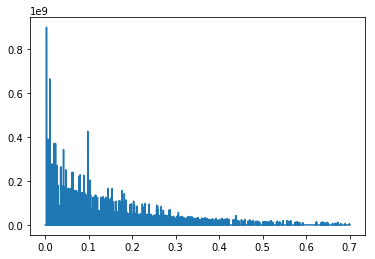

In [156]:
x = np.arange(len(ir))/room.fs
plt.figure()
plt.plot(x, ir)
plt.show()

In [157]:
# Displaying original sound
IPython.display.Audio(audio_anechoic, rate=fs0)

In [158]:

# Compute the convolution
# Set result in the range of np.int16

result = scipy.signal.fftconvolve(ir, audio_anechoic)
result /= np.abs(result).max()
result -= np.mean(result)
result *= 32767
result = np.round(result)  # Set to integer number
result = result.astype(np.int16)

In [159]:
# Displaying the modified sound
wavfile.write("with_echo.wav", rate=fs0, data=result)
fs, audio_result = wavfile.read("with_echo.wav")


IPython.display.Audio(audio_result, rate=fs)

In [90]:
R = np.array([[mic_pos[0],1.], [mic_pos[1], 1]])  # [ [xs], [ys]]

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

# compute image sources
room.image_source_model(use_libroom=True)

/home/cyril/anaconda3/lib/python3.6/site-packages/pyroomacoustics/soundsource.py:215: RuntimeWarning: divide by zero encountered in true_divide
  alpha = self.damping / (4.*np.pi*dist)
/home/cyril/anaconda3/lib/python3.6/site-packages/pyroomacoustics/soundsource.py:237: RuntimeWarning: invalid value encountered in multiply
  ir[time_ip-fdl2:time_ip+fdl2+1] += alpha[i]*fractional_delay(time_fp)


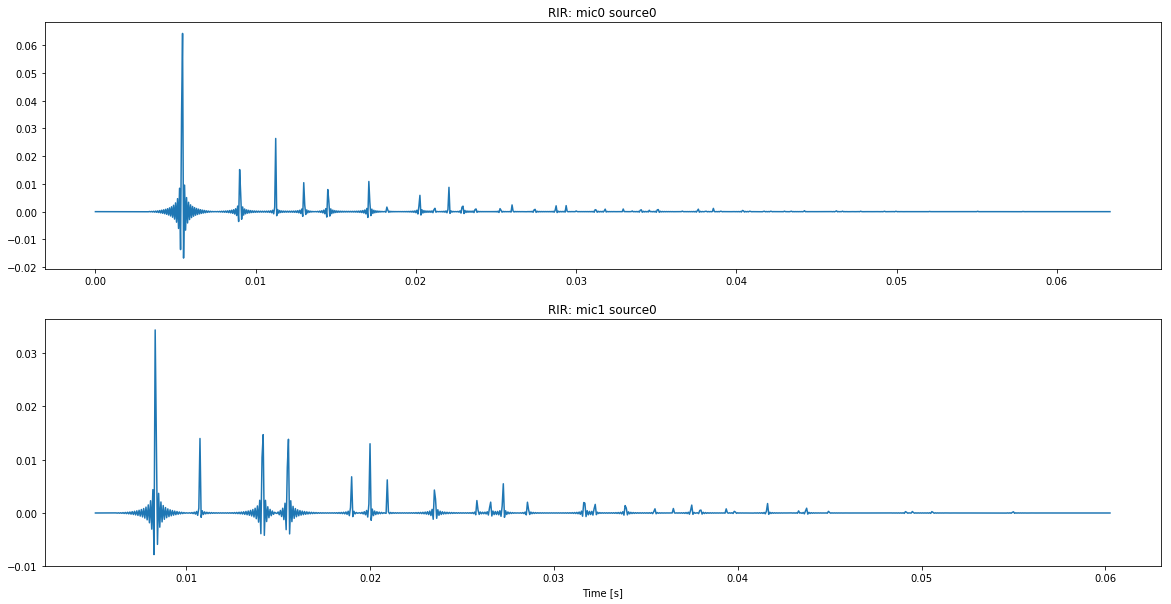

In [91]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [92]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 167454)


In [93]:
# original signal
print("Original WAV:")
IPython.display.Audio(audio_anechoic, rate=fs)

Original WAV:


In [94]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:
